In [1]:
import os

import hydra
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch import Tensor, nn
from torch.nn.functional import softmax

from skin_disease_recognition.core.config import MODEL_DIR, PROJECT_ROOT
from skin_disease_recognition.data.loaders import make_loaders

In [2]:
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()
hydra.initialize(version_base=None, config_path='../conf')
cfg = hydra.compose(config_name='config.yaml')

In [3]:
device = cfg.device

In [4]:
model: nn.Module = torch.load(
    MODEL_DIR / 'efficientnetb0_weight_decay.pth',
    weights_only=False,
    map_location=torch.device(device),
).to(device)

In [5]:
os.chdir(PROJECT_ROOT)

In [6]:
train_loader, test_loader = make_loaders(cfg)

In [7]:
y_preds = []
y_trues = []

In [8]:
high_miss = []
low_miss = []

miss_probs = []

In [9]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        images: Tensor
        labels: Tensor
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        pred: Tensor = softmax(model(images), 1)
        pred_label = torch.argmax(pred, dim=1)

        for j, (p, lab) in enumerate(zip(pred_label, labels, strict=True)):
            if p != lab:
                miss_probs.append(pred[j][p].item())
            if p != lab and pred[j][p] > 0.99:
                entry = (images[j], p, lab, pred[j][p])
                high_miss.append(entry)
            if p != lab and pred[j][p] < 0.4:
                entry = (images[j], p, lab, pred[j][p])
                low_miss.append(entry)

        y_preds.extend(pred_label.cpu())
        y_trues.extend(labels.cpu())

In [10]:
classes = test_loader.dataset.classes

### classification report

In [11]:
print(classification_report(y_true=y_trues, y_pred=y_preds, target_names=classes))

                     precision    recall  f1-score   support

               Acne       0.87      0.89      0.88        65
  Actinic_Keratosis       0.78      0.83      0.81        83
      Benign_tumors       0.73      0.79      0.75       121
            Bullous       0.77      0.65      0.71        55
        Candidiasis       0.73      0.81      0.77        27
       DrugEruption       0.74      0.74      0.74        61
             Eczema       0.81      0.71      0.75       112
 Infestations_Bites       0.69      0.62      0.65        60
             Lichen       0.76      0.72      0.74        61
              Lupus       0.74      0.59      0.66        34
              Moles       0.62      0.65      0.63        40
          Psoriasis       0.69      0.74      0.71        88
            Rosacea       0.86      0.86      0.86        28
  Seborrh_Keratoses       0.82      0.82      0.82        51
         SkinCancer       0.76      0.62      0.69        77
Sun_Sunlight_Damage    

### confusion matrix

In [12]:
conf = confusion_matrix(y_trues, y_preds)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

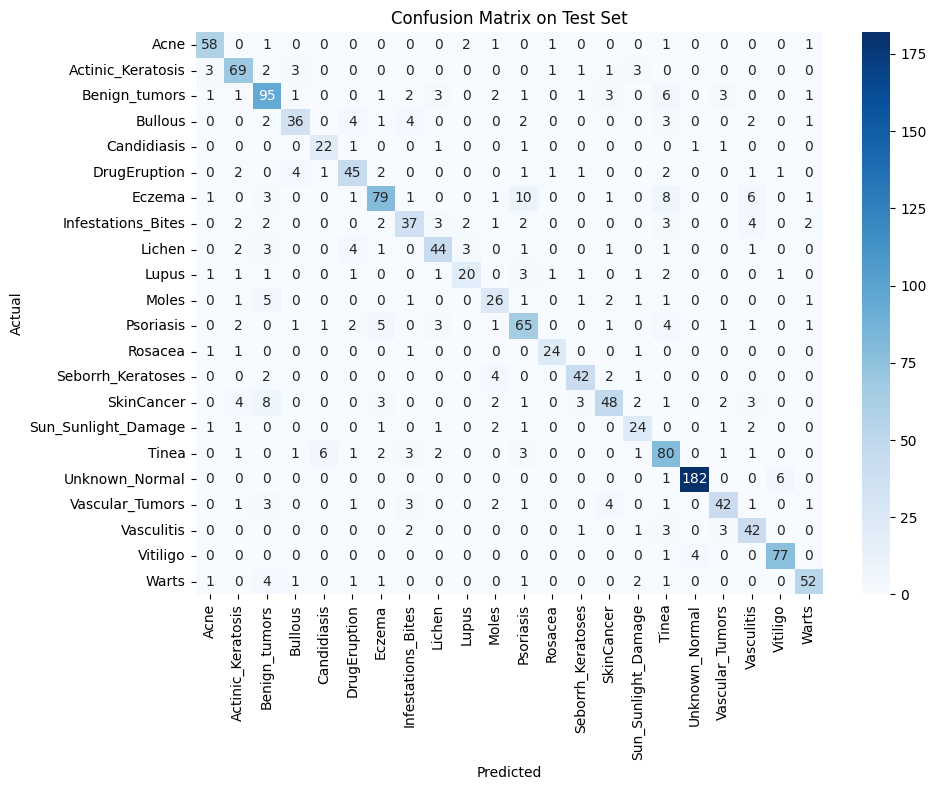

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes
)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
def plot_missclassification(case, cls_names):
    img: Tensor = case[0]
    img = img.permute(1, 2, 0)
    img = img * 0.5 + 0.5
    plt.imshow(img.cpu())
    pred_class = cls_names[case[1]]
    true_class = cls_names[case[2]]
    prob = case[3]
    plt.title(f'Real: {true_class} / Predicted: {pred_class} / Prob: {prob}')

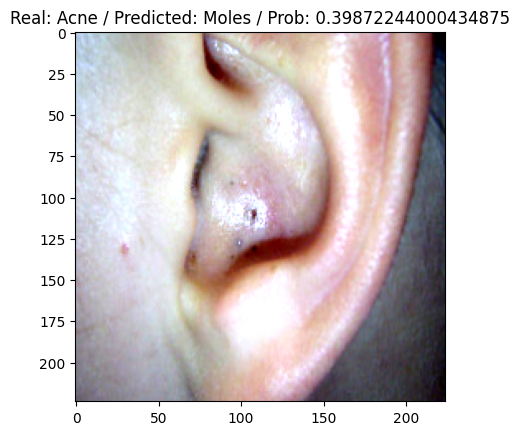

In [18]:
plot_missclassification(low_miss[0], classes)

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(miss_probs, bins=100)
plt.title('Prediction value of missclassified samples')